### IDENTIFYING THE BEST TEAMS IN TERMS OF SET PIECES IN THE WORLD CUP 2022

In [1]:
from statsbombpy import sb
import pandas as pd

##### Read and clean the data

In [2]:
# Read the WC 2022 data
df=pd.DataFrame(sb.matches(competition_id=43, season_id=106))

passes_global = pd.DataFrame()  # DataFrame for the passes
shots_global = pd.DataFrame()   # DataFrame for the shots

for match in df.match_id.unique():
    event = sb.events(match_id=match)
    passes = event[event['type']=='Pass']
    shots = event[event['type']=='Shot']

    passes_global = pd.concat([passes_global, passes], ignore_index=True)
    shots_global = pd.concat([shots_global, shots], ignore_index=True)


c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-pack

##### Get the passes from set pieces

In [27]:
# Filter for passes that lead to a shot or a goal
setpieces_passes = passes_global[(passes_global['pass_goal_assist'] == True) | (passes_global['pass_shot_assist'] == True)]

# Filter for passes from setpieces plays
setpieces = ['From Corner','From Throw in','From Free Kick']
setpieces_passes = setpieces_passes[setpieces_passes['play_pattern'].isin(setpieces)]

# Select the columns that we want 
columns=['id','team','pass_assisted_shot_id']
setpieces_passes = setpieces_passes[columns]
display(setpieces_passes)


,id,team,pass_assisted_shot_id
59,6211767c-543c-48ec-ab72-10eb7928e569,Serbia,6ac240f5-8b84-4c06-8153-b56109c8c5e6
139,00aa3124-ef55-494c-936d-dc337064410b,Switzerland,b6e10a35-3d7a-40ac-b68e-7118fffbe9ab
198,efecda09-b02e-4f1a-aed9-49a0124f43d8,Switzerland,c7c1917b-2c74-40a4-94a0-dc7a9137a766
222,beb0878d-92a3-4b67-b95b-717bc32c3b3b,Serbia,aaae9647-f552-4341-8d43-de39a7facbee
306,dc75f899-b817-404c-bae0-82b3b1926d29,Switzerland,6cee2bd6-3370-4a3f-9a1e-a580d18e8809
...,...,...,...
67893,e4b6ac8c-3d97-4f91-969d-12184fec64d6,Tunisia,d9c9a2e4-f4e8-4b2d-b5d9-ae487ede5201
67981,5253bc8a-c3c2-450d-8462-5cbd48d55b77,Tunisia,bdb5c9fd-eba3-4835-b67b-ffe09d8ac26f
68052,7b47b3f9-3ed2-4957-956a-ae113386c4b1,Tunisia,1cad59c4-1b97-4a22-8523-45b7326946cb
68279,f79126f0-964e-45b9-9b67-f700253ad537,Denmark,4938830d-5631-47d0-89e9-3985a24619a3


##### Get the shots from the passes

In [28]:
# We get the shots from the passes
shots = shots_global[['id','team','shot_statsbomb_xg']]
setpieces_shots = pd.DataFrame(columns=['id','team','shot_statsbomb_xg'])

for index, row in setpieces_passes.iterrows():
    id_shot = row['pass_assisted_shot_id']
    for shot in shots.id.unique():
        if id_shot == shot:
            setpieces_shots = pd.concat([setpieces_shots,shots[shots['id']==shot]],ignore_index=True)

##### Transform and merge the data

In [29]:
# Get the total xG for each team
setpieces_shots = setpieces_shots.groupby('team').sum('shot_statsbomb_xg').reset_index()

# Get the total number of passes for each team
setpieces_passes = setpieces_passes.groupby('team').size().reset_index()
setpieces_passes.columns = ['team','n_passes']

# Merge the data
merged_data = pd.merge(setpieces_shots,setpieces_passes, on='team',how='inner')

# Get the xG per pass and sort the dataframe
merged_data['xG/pass'] = merged_data['shot_statsbomb_xg']/merged_data['n_passes']
top = merged_data.sort_values(by='xG/pass', ascending=False)

##### Which teams are great in set pieces? And do they take advantage of it?

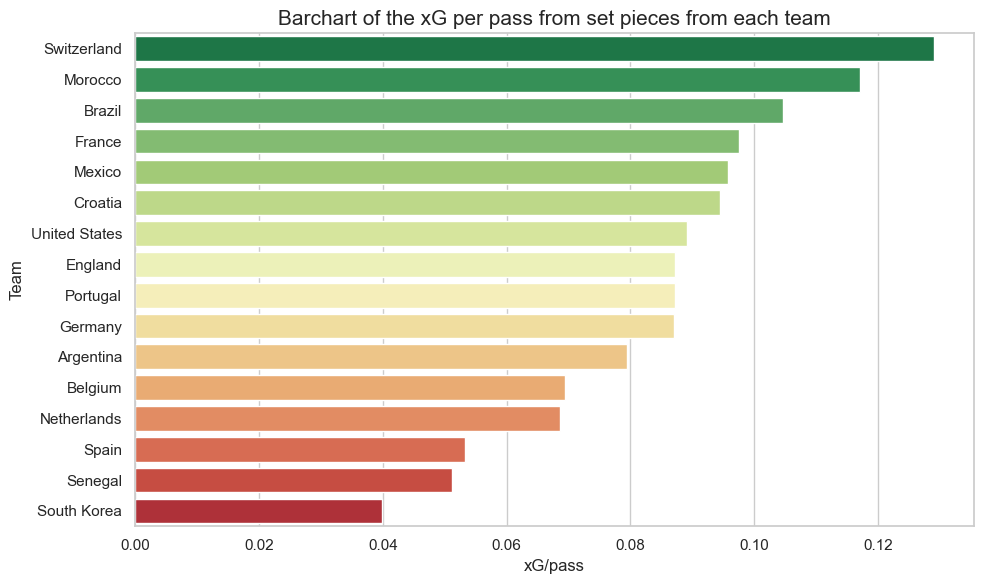

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
sns.set(style="whitegrid")

# Threshold of minimum 10 passes
top = top[top['n_passes']>=10]

# Colors from green to red
colors = sns.color_palette("RdYlGn_r", len(top))

plot = sns.barplot(x='xG/pass', y='team', data=top, palette=colors)

plt.xlabel('xG/pass')
plt.ylabel('Team')
plt.title('Barchart of the xG per pass from set pieces from each team',fontsize=15)

plt.tight_layout()

plt.savefig('../img/Barchartxgpass.png')

plt.show()